Recurrent Neural Networks (RNN)
====================

In this exercise we will work with Recurrent Neural Networks (RNN). A RNN is class of neural networks where the output not only depends on the current input but also on previous inputs along a given input sequence. This allows to exhibit temporal dynamic behaviour and contextual information in a sequence. Common applications for RNN are:

- time series analysis
- speech recognition
- machine translation
- image captioning


Goal of this exercise
========

This exercise notebook should help you to experiment how recurrent neural networks are implemented, trained, and used for computer vision problems. Therefore, this notebook is structured as follows:
1. Implement your own simple RNN class in Pytorch.
2. Explore the backpropagation of the gradients in the RNN and discuss the vanishing gradient problem.
3. Implement your own LSTM (Long-Short Term Memory) Network and show that this architecture improves the vanishing gradient problem.
4. Build a RNN classifier for the MNIST dataset and train your model.
5. Tune the hyperparameters of your model and submit your best model to the server to get bonus points.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import platform
print('Using python: ', platform.python_version())
print('Using torch version: ', torch.__version__)
print('Using device: ', device)
# Machine: 2015 13" Macbook Pro, i5 dual core

Using python:  3.6.3
Using torch version:  1.0.0
Using device:  cpu


## Simple Recurrent Neural Network

The recurrent loops in a RNN allow relevant information to persist over time. A simple RNN architecture is shown here:
<img src=http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-rolled.png width="150">

A simple RNN takes not only an input X at time step t but also passes a hidden state that is the output of the previous time step into the network. The output of a RNN cell at time step t reads in Eq. 1:

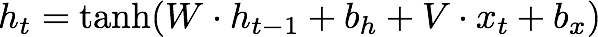

In this task you have to implement a simple one-layer RNN as a class in Pytorch, where you can choose a relu or tanh activation in the cell.You can see the architecture of a simple RNN in the figure below.


<img src=http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png width="600">



In [19]:
# ToDo: Implement the RNN class


Luckily, Pytorch already has implemented a simple RNN in their library and you can call the RNN with <code>nn.RNN</code>. We will use the Pytorch RNN function to check if we have built the correct cell and compare the output of both functions. We also compare the running time of both classes.

In [62]:
import torch.nn as nn
import timeit
from exercise_code.rnn.rnn_nn import RNN

# choose your network parameters
input_size=3
hidden_dim=3
seq_len= 10 

# define the two models
pytorch_rnn=nn.RNN(input_size, hidden_dim)
i2dl_rnn=RNN(input_size, hidden_dim)

# initialise both rnn with same values
for p in pytorch_rnn.parameters():
    nn.init.constant_(p, val=0.3)
for p in i2dl_rnn.parameters():
    nn.init.constant_(p, val=0.3)
    
X=torch.randn(seq_len, 1, input_size)

output_pytorch, h_pytorch = pytorch_rnn(X)
output_i2dl, h_i2dl = i2dl_rnn(X)


# The difference of outputs should be 0!!

diff = torch.sum((output_pytorch-output_i2dl)**2)
print("Differnce between pytorch and your RNN implementation: %s" %diff.item())
if diff.item()<10**-10:
    print("Cool, you implemented a correct model.")
else:
    print("Upps! There is something wrong in your model. Try again!")

Differnce between pytorch and your RNN implementation: 0.0
Cool, you implemented a correct model.


In [63]:
import timeit
runs=10**4

print("Time Pytorch RNN {} runs: {:.3f}s".format(runs, timeit.timeit("pytorch_rnn(X)", 
                                       setup="from __main__ import pytorch_rnn, X", 
                                       number=runs))
     )

print("Time I2DL RNN {} run: {:.3f}s".format(runs, timeit.timeit("i2dl_rnn(X)", 
                                       setup="from __main__ import i2dl_rnn, X", 
                                       number=runs))
     )

Time Pytorch RNN 10000 runs: 3.306s
Time I2DL RNN 10000 run: 9.560s


From now on we will use the Pytorch module that is faster and optimised in performance. However, it is always a good exercise to build the functions by yourself and we really advice you to do the exercise!

## Vanishing Gradient

As discussed in the lecture, the simple RNN suffers from vanishing gradients in the backpropagation. The hidden state is manipulated in every time step along the sequence and the effect of the past inputs to the final output vanishes with the distance in time. In the next cell we will explore the vanishing effect of previous inputs in the RNN.

In [82]:
############################################################################
# TODO: Define a RNN and explore the gradients on the output h_T wrt. the  #
# input at time t and plot your result. What behaviour do you observe?     #
# Hints:                                                                   #
#   - use one input feature                                                #
#   - pytorch allows backward() pass wrt. to any vector                    #
#   - backward() can only be applied to scalars and not to output tensors  #
#   - choose a good representation of the gradient plot                    #
############################################################################
my_rnn = nn.RNN(10, 10, 2)
input_ = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 10)
output_, hn = my_rnn(input, h0)

loss = nn.MSELoss()
target =  torch.randn(5, 3, 10)
out = loss(output_, target)
out.backward()
print(input_.grad)

############################################################################
#                             END OF YOUR CODE                             #
############################################################################

None



<div class="alert alert-info">
    <h3>Note</h3>
    <p>It can be seen that the gradient of the of the output at time t wrt. to a previous input decreases exponentially. Hence, the final output does not change significantly for changes in the previous input and hence the RNN does not have memory.</p> 
<h3>Question</h3> 
<p>In order to better understand the vanishing gradient problem, calculate the gradients 
dh_t/dV, dh_t /dW, and dh_t/dX_0 analytically for t=3 and h_0=0 using Eq. 1. This exercise might seem a little bit tedious but it is really useful. Can you explain the vanishing gradient mathematically based on your findings?</p>
</div>

## Long-Short Term Memory Network (LSTM)
The vanishing gradient problem had been known for some time until Schmidhuber (1997) developed the Long-Short Term Memory Network and showed that this architecture can overcome the problem. <br> 
A LSTM is a more advanced recurrent network architecture that is able to learn long time dependencies. The architecture of a LSTM is composed of a forget, input, and output gate and the cell can remember values over arbitrary time intervals. Despite various different and exotic LSTM architectures, the standard LSTM cell is shwon in the figure below:


<img src=http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png width="600">



Compared to a simple RNN the LSTM cell has a hidden vector and an additional cell state vector. __What size does the cell state have?__ <br>
The operations inside the LSTM are given as 

<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/2db2cba6a0d878e13932fa27ce6f3fb71ad99cf1  width="600">
where 
f_t: forget gate,  <br>
i_t: input gate, <br>
o_t: output gate, <br>
h_t: hidden state vector, <br>
c_t: cell state vector, <br>
x_t: input vector, <br>
t is time step, 
<br> 
<br> 
and<br> 
sigma_g: sigmoid activation <br> 
sigma_c and sigma_h: hyperbolic tangent function


In the next step you should implement your own LSTM with the operations stated above.

In [ ]:
# ToDo: Implement the RNN class
from exercise_code.rnn.rnn_nn import LSTM

In [ ]:

# choose your input parameters
input_size=3
hidden_dim=3
seq_len= 10 

# define the two models
pytorch_lstm=nn.LSTM(input_size, hidden_dim)
i2dl_lstm=LSTM(input_size, hidden_dim)

# initialise both lstms with same values
for p in pytorch_lstm.parameters():
    nn.init.constant_(p, val=0.3)
for p in i2dl_lstm.parameters():
    nn.init.constant_(p, val=0.3)
    
X=torch.randn(seq_len, 1, input_size)

output_pytorch, (h_pytorch, _) = pytorch_lstm(X)
output_i2dl , (h_i2dl, _ )= i2dl_lstm(X)

# The difference of outputs should be 0!!
diff = torch.sum((output_pytorch-output_i2dl)**2)
print("Differnce between pytorch and your RNN implementation: %s" %diff.item())
if diff.item()<10**-10:
    print("Cool, you implemented a correct model.")
else:
    print("Upps! There is something wrong in your model. Try again!")

In [ ]:
import timeit
runs=10**4

print("Time Pytorch LSTM {} runs: {:.3f}s".format(runs, timeit.timeit("pytorch_lstm(X)", 
                                       setup="from __main__ import pytorch_lstm, X", 
                                       number=runs))
     )

print("Time I2DL LSTM {} run: {:.3f}s".format(runs, timeit.timeit("i2dl_lstm(X)", 
                                       setup="from __main__ import i2dl_lstm, X", 
                                       number=runs))
     )

## Explore Gradients 
Analogously to the RNN, calculate the gradients of the input wrt. to the output of the LSTM and compare it against the RNN gradients. __What do you see?__


In [ ]:
############################################################################
# TODO: Define a RNN and LSTM and explore the gradients on the output h_T   #
# wrt. the input at time t and plot your result.                           #
############################################################################
pass
############################################################################
#                             END OF YOUR CODE                             #
############################################################################

## MNIST image classification with RNNs

In the previous exercises we already have classified images with a Fully Connected and Convolutional Network. In this exercise, we will solve the problem of image classification with a recurrent neural network.  

For the experiment we use the MNIST handwritten digits dataset which we already know from the autoencoder exercise. This dataset consists of images of the 10 different digits (10 classes). The images have the resolution 28 x 28. The idea for the RNN classifier is to interpret the image as a sequence of rows. This means that we pass the rows through the RNN and use the final hidden state for classification. 


<div class="alert alert-info">
    <h3>Note</h3>
    <p>
    In this semester you have seen three different types of neural networks, namely Multi-Layer Perceptrons (MLPs), Convolutional Neural Networks (CNNs), and now Recurrent Neural Networks (RNNs). We have seen that we can use all three architectures for image classification. However, it turned out that some models are better than others for image classification. Try to think about advantages and disadvantages of the models, regarding # of parameters, transformations of the object in the image (scaling, rotation, translation,...), training time, testing time, over-fitting, etc.

In [85]:
# Define data loader
from torchvision import transforms
import pickle

class Unsqueeze(object):
    """Adds a channel dimension that that our 2 dimensional input (H, W), 
    fits the 3 dimensional (H, W, C) expectations of pytorch's ToTensor function which
    expects a PIL image. This is very inefficient but you most probably will use pytorch's
    PIL image loader. Check out the documentation and make it more efficient :)
    """
    def __init__(self, dimension=0):
        self.dimension = dimension
    def __call__(self, numpy_array):
        extended_array = np.expand_dims(numpy_array, self.dimension)
        return extended_array
    def __repr__(self):
        return self.__class__.__name__ + 'dimension={}'.format(dimension)

    
# transformation of data
transform = transforms.Compose([
    Unsqueeze(dimension=3),     
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])


class MnistDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, 
                 transform=None):
        super(MnistDataset, self).__init__()
        self.images = images
        self.labels = labels
        self.transform = transform
       
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform: 
            image = self.transform(image)
        return image, label

    
# loading the train data
with open("datasets/mnist_train.p", "rb") as f:
    mnist_raw = pickle.load(f)

X, y= mnist_raw
############################################################################
# TODO: Set a useful training/ validation split                            #
############################################################################    

train_split=0.6

############################################################################
#                             END OF YOUR CODE                             #
############################################################################


train_dset=MnistDataset(X[:int(len(X)*train_split)], y[:int(len(X)*train_split)], transform=transform)
val_dset=MnistDataset(X[int(len(X)*train_split):], y[int(len(X)*train_split):], transform=transform)


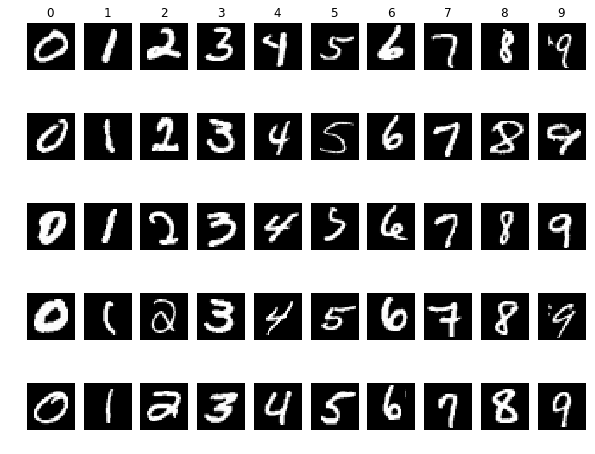

In [84]:
# Visualize some examples from the dataset. Stolen from other notebooks
# We show a few examples of training images from each class.
X=train_dset.images
y=train_dset.labels


classes = list(range(10))
num_classes = len(classes)
samples_per_class = 5
for y_hat, cls in enumerate(classes):
    idxs = np.flatnonzero(train_dset.labels == y_hat)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y_hat + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Build a classifier based on a RNN where you sequentially feed the rows in the network and use the final hidden state for prediction.

<img src=https://cdn-images-1.medium.com/max/800/1*Cm_c-I02rBa1rtLZXBhNUw.png width="600">


In [92]:
from exercise_code.rnn.rnn_nn import RNN_Classifier
model_rnn = RNN_Classifier()


In [93]:
from exercise_code.rnn.solver import Solver

In [94]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
                 dataset=train_dset,
                 batch_size=batch_size,
                 shuffle=True)
val_loader = torch.utils.data.DataLoader(
                dataset=val_dset,
                batch_size=batch_size,
                shuffle=False)

solver = Solver(optim_args={"lr": 1e-3})

# train rnn model
solver.train(model_rnn, train_loader, val_loader, log_nth=1, num_epochs=10)

START TRAIN.
[Iteration 1/2820] TRAIN loss: 2.328
[Iteration 2/2820] TRAIN loss: 2.311
[Iteration 3/2820] TRAIN loss: 2.324
[Iteration 4/2820] TRAIN loss: 2.299


/Users/samwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


[Iteration 5/2820] TRAIN loss: 2.291
[Iteration 6/2820] TRAIN loss: 2.283
[Iteration 7/2820] TRAIN loss: 2.299
[Iteration 8/2820] TRAIN loss: 2.264
[Iteration 9/2820] TRAIN loss: 2.307
[Iteration 10/2820] TRAIN loss: 2.278
[Iteration 11/2820] TRAIN loss: 2.283
[Iteration 12/2820] TRAIN loss: 2.250
[Iteration 13/2820] TRAIN loss: 2.208
[Iteration 14/2820] TRAIN loss: 2.247
[Iteration 15/2820] TRAIN loss: 2.210
[Iteration 16/2820] TRAIN loss: 2.181
[Iteration 17/2820] TRAIN loss: 2.170
[Iteration 18/2820] TRAIN loss: 2.109
[Iteration 19/2820] TRAIN loss: 2.086
[Iteration 20/2820] TRAIN loss: 2.172
[Iteration 21/2820] TRAIN loss: 2.058
[Iteration 22/2820] TRAIN loss: 2.073
[Iteration 23/2820] TRAIN loss: 1.943
[Iteration 24/2820] TRAIN loss: 1.952
[Iteration 25/2820] TRAIN loss: 1.900
[Iteration 26/2820] TRAIN loss: 1.925
[Iteration 27/2820] TRAIN loss: 1.936
[Iteration 28/2820] TRAIN loss: 1.828
[Iteration 29/2820] TRAIN loss: 1.882
[Iteration 30/2820] TRAIN loss: 1.799
[Iteration 31/282

[Iteration 222/2820] TRAIN loss: 1.013
[Iteration 223/2820] TRAIN loss: 0.764
[Iteration 224/2820] TRAIN loss: 0.759
[Iteration 225/2820] TRAIN loss: 0.810
[Iteration 226/2820] TRAIN loss: 0.848
[Iteration 227/2820] TRAIN loss: 0.830
[Iteration 228/2820] TRAIN loss: 0.681
[Iteration 229/2820] TRAIN loss: 0.755
[Iteration 230/2820] TRAIN loss: 0.837
[Iteration 231/2820] TRAIN loss: 0.930
[Iteration 232/2820] TRAIN loss: 0.755
[Iteration 233/2820] TRAIN loss: 0.670
[Iteration 234/2820] TRAIN loss: 0.755
[Iteration 235/2820] TRAIN loss: 0.662
[Iteration 236/2820] TRAIN loss: 0.746
[Iteration 237/2820] TRAIN loss: 0.666
[Iteration 238/2820] TRAIN loss: 0.675
[Iteration 239/2820] TRAIN loss: 0.632
[Iteration 240/2820] TRAIN loss: 0.636
[Iteration 241/2820] TRAIN loss: 0.742
[Iteration 242/2820] TRAIN loss: 0.647
[Iteration 243/2820] TRAIN loss: 0.561
[Iteration 244/2820] TRAIN loss: 0.678
[Iteration 245/2820] TRAIN loss: 0.583
[Iteration 246/2820] TRAIN loss: 0.594
[Iteration 247/2820] TRAI

[Iteration 433/2820] TRAIN loss: 0.679
[Iteration 434/2820] TRAIN loss: 0.550
[Iteration 435/2820] TRAIN loss: 0.481
[Iteration 436/2820] TRAIN loss: 0.448
[Iteration 437/2820] TRAIN loss: 0.529
[Iteration 438/2820] TRAIN loss: 0.523
[Iteration 439/2820] TRAIN loss: 0.656
[Iteration 440/2820] TRAIN loss: 0.459
[Iteration 441/2820] TRAIN loss: 0.480
[Iteration 442/2820] TRAIN loss: 0.647
[Iteration 443/2820] TRAIN loss: 0.449
[Iteration 444/2820] TRAIN loss: 0.456
[Iteration 445/2820] TRAIN loss: 0.360
[Iteration 446/2820] TRAIN loss: 0.489
[Iteration 447/2820] TRAIN loss: 0.384
[Iteration 448/2820] TRAIN loss: 0.594
[Iteration 449/2820] TRAIN loss: 0.418
[Iteration 450/2820] TRAIN loss: 0.617
[Iteration 451/2820] TRAIN loss: 0.642
[Iteration 452/2820] TRAIN loss: 0.490
[Iteration 453/2820] TRAIN loss: 0.583
[Iteration 454/2820] TRAIN loss: 0.484
[Iteration 455/2820] TRAIN loss: 0.559
[Iteration 456/2820] TRAIN loss: 0.358
[Iteration 457/2820] TRAIN loss: 0.583
[Iteration 458/2820] TRAI

[Iteration 644/2820] TRAIN loss: 0.346
[Iteration 645/2820] TRAIN loss: 0.377
[Iteration 646/2820] TRAIN loss: 0.529
[Iteration 647/2820] TRAIN loss: 0.506
[Iteration 648/2820] TRAIN loss: 0.410
[Iteration 649/2820] TRAIN loss: 0.437
[Iteration 650/2820] TRAIN loss: 0.373
[Iteration 651/2820] TRAIN loss: 0.614
[Iteration 652/2820] TRAIN loss: 0.393
[Iteration 653/2820] TRAIN loss: 0.450
[Iteration 654/2820] TRAIN loss: 0.518
[Iteration 655/2820] TRAIN loss: 0.340
[Iteration 656/2820] TRAIN loss: 0.614
[Iteration 657/2820] TRAIN loss: 0.370
[Iteration 658/2820] TRAIN loss: 0.310
[Iteration 659/2820] TRAIN loss: 0.291
[Iteration 660/2820] TRAIN loss: 0.457
[Iteration 661/2820] TRAIN loss: 0.270
[Iteration 662/2820] TRAIN loss: 0.431
[Iteration 663/2820] TRAIN loss: 0.608
[Iteration 664/2820] TRAIN loss: 0.607
[Iteration 665/2820] TRAIN loss: 0.507
[Iteration 666/2820] TRAIN loss: 0.517
[Iteration 667/2820] TRAIN loss: 0.481
[Iteration 668/2820] TRAIN loss: 0.441
[Iteration 669/2820] TRAI

[Iteration 855/2820] TRAIN loss: 0.400
[Iteration 856/2820] TRAIN loss: 0.339
[Iteration 857/2820] TRAIN loss: 0.383
[Iteration 858/2820] TRAIN loss: 0.334
[Iteration 859/2820] TRAIN loss: 0.238
[Iteration 860/2820] TRAIN loss: 0.392
[Iteration 861/2820] TRAIN loss: 0.316
[Iteration 862/2820] TRAIN loss: 0.374
[Iteration 863/2820] TRAIN loss: 0.419
[Iteration 864/2820] TRAIN loss: 0.286
[Iteration 865/2820] TRAIN loss: 0.279
[Iteration 866/2820] TRAIN loss: 0.226
[Iteration 867/2820] TRAIN loss: 0.301
[Iteration 868/2820] TRAIN loss: 0.261
[Iteration 869/2820] TRAIN loss: 0.368
[Iteration 870/2820] TRAIN loss: 0.381
[Iteration 871/2820] TRAIN loss: 0.262
[Iteration 872/2820] TRAIN loss: 0.312
[Iteration 873/2820] TRAIN loss: 0.290
[Iteration 874/2820] TRAIN loss: 0.302
[Iteration 875/2820] TRAIN loss: 0.415
[Iteration 876/2820] TRAIN loss: 0.336
[Iteration 877/2820] TRAIN loss: 0.568
[Iteration 878/2820] TRAIN loss: 0.289
[Iteration 879/2820] TRAIN loss: 0.357
[Iteration 880/2820] TRAI

[Iteration 1065/2820] TRAIN loss: 0.346
[Iteration 1066/2820] TRAIN loss: 0.285
[Iteration 1067/2820] TRAIN loss: 0.267
[Iteration 1068/2820] TRAIN loss: 0.375
[Iteration 1069/2820] TRAIN loss: 0.294
[Iteration 1070/2820] TRAIN loss: 0.302
[Iteration 1071/2820] TRAIN loss: 0.244
[Iteration 1072/2820] TRAIN loss: 0.381
[Iteration 1073/2820] TRAIN loss: 0.297
[Iteration 1074/2820] TRAIN loss: 0.328
[Iteration 1075/2820] TRAIN loss: 0.172
[Iteration 1076/2820] TRAIN loss: 0.249
[Iteration 1077/2820] TRAIN loss: 0.169
[Iteration 1078/2820] TRAIN loss: 0.285
[Iteration 1079/2820] TRAIN loss: 0.241
[Iteration 1080/2820] TRAIN loss: 0.341
[Iteration 1081/2820] TRAIN loss: 0.281
[Iteration 1082/2820] TRAIN loss: 0.357
[Iteration 1083/2820] TRAIN loss: 0.162
[Iteration 1084/2820] TRAIN loss: 0.241
[Iteration 1085/2820] TRAIN loss: 0.317
[Iteration 1086/2820] TRAIN loss: 0.317
[Iteration 1087/2820] TRAIN loss: 0.220
[Iteration 1088/2820] TRAIN loss: 0.253
[Iteration 1089/2820] TRAIN loss: 0.183


[Iteration 1268/2820] TRAIN loss: 0.122
[Iteration 1269/2820] TRAIN loss: 0.071
[Iteration 1270/2820] TRAIN loss: 0.223
[Iteration 1271/2820] TRAIN loss: 0.167
[Iteration 1272/2820] TRAIN loss: 0.113
[Iteration 1273/2820] TRAIN loss: 0.229
[Iteration 1274/2820] TRAIN loss: 0.232
[Iteration 1275/2820] TRAIN loss: 0.122
[Iteration 1276/2820] TRAIN loss: 0.148
[Iteration 1277/2820] TRAIN loss: 0.167
[Iteration 1278/2820] TRAIN loss: 0.206
[Iteration 1279/2820] TRAIN loss: 0.184
[Iteration 1280/2820] TRAIN loss: 0.228
[Iteration 1281/2820] TRAIN loss: 0.178
[Iteration 1282/2820] TRAIN loss: 0.109
[Iteration 1283/2820] TRAIN loss: 0.211
[Iteration 1284/2820] TRAIN loss: 0.261
[Iteration 1285/2820] TRAIN loss: 0.315
[Iteration 1286/2820] TRAIN loss: 0.183
[Iteration 1287/2820] TRAIN loss: 0.161
[Iteration 1288/2820] TRAIN loss: 0.181
[Iteration 1289/2820] TRAIN loss: 0.353
[Iteration 1290/2820] TRAIN loss: 0.224
[Iteration 1291/2820] TRAIN loss: 0.152
[Iteration 1292/2820] TRAIN loss: 0.162


[Iteration 1473/2820] TRAIN loss: 0.128
[Iteration 1474/2820] TRAIN loss: 0.207
[Iteration 1475/2820] TRAIN loss: 0.199
[Iteration 1476/2820] TRAIN loss: 0.278
[Iteration 1477/2820] TRAIN loss: 0.242
[Iteration 1478/2820] TRAIN loss: 0.157
[Iteration 1479/2820] TRAIN loss: 0.197
[Iteration 1480/2820] TRAIN loss: 0.182
[Iteration 1481/2820] TRAIN loss: 0.144
[Iteration 1482/2820] TRAIN loss: 0.262
[Iteration 1483/2820] TRAIN loss: 0.189
[Iteration 1484/2820] TRAIN loss: 0.317
[Iteration 1485/2820] TRAIN loss: 0.239
[Iteration 1486/2820] TRAIN loss: 0.255
[Iteration 1487/2820] TRAIN loss: 0.217
[Iteration 1488/2820] TRAIN loss: 0.089
[Iteration 1489/2820] TRAIN loss: 0.158
[Iteration 1490/2820] TRAIN loss: 0.146
[Iteration 1491/2820] TRAIN loss: 0.183
[Iteration 1492/2820] TRAIN loss: 0.181
[Iteration 1493/2820] TRAIN loss: 0.249
[Iteration 1494/2820] TRAIN loss: 0.334
[Iteration 1495/2820] TRAIN loss: 0.205
[Iteration 1496/2820] TRAIN loss: 0.169
[Iteration 1497/2820] TRAIN loss: 0.115


[Iteration 1681/2820] TRAIN loss: 0.219
[Iteration 1682/2820] TRAIN loss: 0.116
[Iteration 1683/2820] TRAIN loss: 0.147
[Iteration 1684/2820] TRAIN loss: 0.228
[Iteration 1685/2820] TRAIN loss: 0.101
[Iteration 1686/2820] TRAIN loss: 0.230
[Iteration 1687/2820] TRAIN loss: 0.130
[Iteration 1688/2820] TRAIN loss: 0.435
[Iteration 1689/2820] TRAIN loss: 0.176
[Iteration 1690/2820] TRAIN loss: 0.086
[Iteration 1691/2820] TRAIN loss: 0.162
[Iteration 1692/2820] TRAIN loss: 0.443
[Epoch 6/10] TRAIN acc/loss: 0.906/0.443
[Epoch 6/10] VAL   acc/loss: 0.918/0.272
[Iteration 1693/2820] TRAIN loss: 0.214
[Iteration 1694/2820] TRAIN loss: 0.249
[Iteration 1695/2820] TRAIN loss: 0.224
[Iteration 1696/2820] TRAIN loss: 0.379
[Iteration 1697/2820] TRAIN loss: 0.256
[Iteration 1698/2820] TRAIN loss: 0.307
[Iteration 1699/2820] TRAIN loss: 0.135
[Iteration 1700/2820] TRAIN loss: 0.177
[Iteration 1701/2820] TRAIN loss: 0.097
[Iteration 1702/2820] TRAIN loss: 0.087
[Iteration 1703/2820] TRAIN loss: 0.26

[Iteration 1886/2820] TRAIN loss: 0.138
[Iteration 1887/2820] TRAIN loss: 0.159
[Iteration 1888/2820] TRAIN loss: 0.154
[Iteration 1889/2820] TRAIN loss: 0.192
[Iteration 1890/2820] TRAIN loss: 0.143
[Iteration 1891/2820] TRAIN loss: 0.090
[Iteration 1892/2820] TRAIN loss: 0.259
[Iteration 1893/2820] TRAIN loss: 0.138
[Iteration 1894/2820] TRAIN loss: 0.126
[Iteration 1895/2820] TRAIN loss: 0.146
[Iteration 1896/2820] TRAIN loss: 0.213
[Iteration 1897/2820] TRAIN loss: 0.162
[Iteration 1898/2820] TRAIN loss: 0.134
[Iteration 1899/2820] TRAIN loss: 0.147
[Iteration 1900/2820] TRAIN loss: 0.080
[Iteration 1901/2820] TRAIN loss: 0.131
[Iteration 1902/2820] TRAIN loss: 0.165
[Iteration 1903/2820] TRAIN loss: 0.184
[Iteration 1904/2820] TRAIN loss: 0.141
[Iteration 1905/2820] TRAIN loss: 0.186
[Iteration 1906/2820] TRAIN loss: 0.132
[Iteration 1907/2820] TRAIN loss: 0.113
[Iteration 1908/2820] TRAIN loss: 0.287
[Iteration 1909/2820] TRAIN loss: 0.111
[Iteration 1910/2820] TRAIN loss: 0.094


[Iteration 2090/2820] TRAIN loss: 0.069
[Iteration 2091/2820] TRAIN loss: 0.097
[Iteration 2092/2820] TRAIN loss: 0.151
[Iteration 2093/2820] TRAIN loss: 0.204
[Iteration 2094/2820] TRAIN loss: 0.105
[Iteration 2095/2820] TRAIN loss: 0.098
[Iteration 2096/2820] TRAIN loss: 0.142
[Iteration 2097/2820] TRAIN loss: 0.198
[Iteration 2098/2820] TRAIN loss: 0.198
[Iteration 2099/2820] TRAIN loss: 0.225
[Iteration 2100/2820] TRAIN loss: 0.167
[Iteration 2101/2820] TRAIN loss: 0.065
[Iteration 2102/2820] TRAIN loss: 0.153
[Iteration 2103/2820] TRAIN loss: 0.235
[Iteration 2104/2820] TRAIN loss: 0.114
[Iteration 2105/2820] TRAIN loss: 0.193
[Iteration 2106/2820] TRAIN loss: 0.171
[Iteration 2107/2820] TRAIN loss: 0.170
[Iteration 2108/2820] TRAIN loss: 0.132
[Iteration 2109/2820] TRAIN loss: 0.198
[Iteration 2110/2820] TRAIN loss: 0.113
[Iteration 2111/2820] TRAIN loss: 0.152
[Iteration 2112/2820] TRAIN loss: 0.168
[Iteration 2113/2820] TRAIN loss: 0.140
[Iteration 2114/2820] TRAIN loss: 0.092


[Iteration 2295/2820] TRAIN loss: 0.108
[Iteration 2296/2820] TRAIN loss: 0.111
[Iteration 2297/2820] TRAIN loss: 0.045
[Iteration 2298/2820] TRAIN loss: 0.140
[Iteration 2299/2820] TRAIN loss: 0.285
[Iteration 2300/2820] TRAIN loss: 0.169
[Iteration 2301/2820] TRAIN loss: 0.167
[Iteration 2302/2820] TRAIN loss: 0.212
[Iteration 2303/2820] TRAIN loss: 0.205
[Iteration 2304/2820] TRAIN loss: 0.312
[Iteration 2305/2820] TRAIN loss: 0.129
[Iteration 2306/2820] TRAIN loss: 0.146
[Iteration 2307/2820] TRAIN loss: 0.231
[Iteration 2308/2820] TRAIN loss: 0.196
[Iteration 2309/2820] TRAIN loss: 0.094
[Iteration 2310/2820] TRAIN loss: 0.178
[Iteration 2311/2820] TRAIN loss: 0.167
[Iteration 2312/2820] TRAIN loss: 0.172
[Iteration 2313/2820] TRAIN loss: 0.142
[Iteration 2314/2820] TRAIN loss: 0.223
[Iteration 2315/2820] TRAIN loss: 0.139
[Iteration 2316/2820] TRAIN loss: 0.134
[Iteration 2317/2820] TRAIN loss: 0.104
[Iteration 2318/2820] TRAIN loss: 0.092
[Iteration 2319/2820] TRAIN loss: 0.231


[Iteration 2504/2820] TRAIN loss: 0.154
[Iteration 2505/2820] TRAIN loss: 0.070
[Iteration 2506/2820] TRAIN loss: 0.060
[Iteration 2507/2820] TRAIN loss: 0.085
[Iteration 2508/2820] TRAIN loss: 0.104
[Iteration 2509/2820] TRAIN loss: 0.264
[Iteration 2510/2820] TRAIN loss: 0.216
[Iteration 2511/2820] TRAIN loss: 0.110
[Iteration 2512/2820] TRAIN loss: 0.188
[Iteration 2513/2820] TRAIN loss: 0.111
[Iteration 2514/2820] TRAIN loss: 0.162
[Iteration 2515/2820] TRAIN loss: 0.088
[Iteration 2516/2820] TRAIN loss: 0.163
[Iteration 2517/2820] TRAIN loss: 0.236
[Iteration 2518/2820] TRAIN loss: 0.158
[Iteration 2519/2820] TRAIN loss: 0.088
[Iteration 2520/2820] TRAIN loss: 0.225
[Iteration 2521/2820] TRAIN loss: 0.277
[Iteration 2522/2820] TRAIN loss: 0.090
[Iteration 2523/2820] TRAIN loss: 0.143
[Iteration 2524/2820] TRAIN loss: 0.133
[Iteration 2525/2820] TRAIN loss: 0.119
[Iteration 2526/2820] TRAIN loss: 0.136
[Iteration 2527/2820] TRAIN loss: 0.147
[Iteration 2528/2820] TRAIN loss: 0.210


[Iteration 2707/2820] TRAIN loss: 0.209
[Iteration 2708/2820] TRAIN loss: 0.243
[Iteration 2709/2820] TRAIN loss: 0.107
[Iteration 2710/2820] TRAIN loss: 0.088
[Iteration 2711/2820] TRAIN loss: 0.233
[Iteration 2712/2820] TRAIN loss: 0.162
[Iteration 2713/2820] TRAIN loss: 0.177
[Iteration 2714/2820] TRAIN loss: 0.117
[Iteration 2715/2820] TRAIN loss: 0.220
[Iteration 2716/2820] TRAIN loss: 0.184
[Iteration 2717/2820] TRAIN loss: 0.113
[Iteration 2718/2820] TRAIN loss: 0.268
[Iteration 2719/2820] TRAIN loss: 0.084
[Iteration 2720/2820] TRAIN loss: 0.128
[Iteration 2721/2820] TRAIN loss: 0.089
[Iteration 2722/2820] TRAIN loss: 0.084
[Iteration 2723/2820] TRAIN loss: 0.143
[Iteration 2724/2820] TRAIN loss: 0.199
[Iteration 2725/2820] TRAIN loss: 0.258
[Iteration 2726/2820] TRAIN loss: 0.197
[Iteration 2727/2820] TRAIN loss: 0.148
[Iteration 2728/2820] TRAIN loss: 0.071
[Iteration 2729/2820] TRAIN loss: 0.220
[Iteration 2730/2820] TRAIN loss: 0.115
[Iteration 2731/2820] TRAIN loss: 0.176


Train your RNN classifier and try to tune the hyperparameters. With your simple RNN classifier you should exceed an accuracy higher than __90%__.

Try to imporve your model by using a LSTM.

In [95]:
from exercise_code.rnn.rnn_nn import LSTM_Classifier
model= LSTM_Classifier()
solver.train(model, train_loader, val_loader, log_nth=1, num_epochs=10)


START TRAIN.
[Iteration 1/2820] TRAIN loss: 2.320


/Users/samwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


[Iteration 2/2820] TRAIN loss: 2.310
[Iteration 3/2820] TRAIN loss: 2.302
[Iteration 4/2820] TRAIN loss: 2.303
[Iteration 5/2820] TRAIN loss: 2.303
[Iteration 6/2820] TRAIN loss: 2.302
[Iteration 7/2820] TRAIN loss: 2.313
[Iteration 8/2820] TRAIN loss: 2.280
[Iteration 9/2820] TRAIN loss: 2.301
[Iteration 10/2820] TRAIN loss: 2.318
[Iteration 11/2820] TRAIN loss: 2.280
[Iteration 12/2820] TRAIN loss: 2.289
[Iteration 13/2820] TRAIN loss: 2.314
[Iteration 14/2820] TRAIN loss: 2.287
[Iteration 15/2820] TRAIN loss: 2.278
[Iteration 16/2820] TRAIN loss: 2.269
[Iteration 17/2820] TRAIN loss: 2.293
[Iteration 18/2820] TRAIN loss: 2.298
[Iteration 19/2820] TRAIN loss: 2.304
[Iteration 20/2820] TRAIN loss: 2.292
[Iteration 21/2820] TRAIN loss: 2.267
[Iteration 22/2820] TRAIN loss: 2.245
[Iteration 23/2820] TRAIN loss: 2.262
[Iteration 24/2820] TRAIN loss: 2.220
[Iteration 25/2820] TRAIN loss: 2.297
[Iteration 26/2820] TRAIN loss: 2.220
[Iteration 27/2820] TRAIN loss: 2.227
[Iteration 28/2820] 

[Iteration 215/2820] TRAIN loss: 0.254
[Iteration 216/2820] TRAIN loss: 0.291
[Iteration 217/2820] TRAIN loss: 0.169
[Iteration 218/2820] TRAIN loss: 0.370
[Iteration 219/2820] TRAIN loss: 0.233
[Iteration 220/2820] TRAIN loss: 0.291
[Iteration 221/2820] TRAIN loss: 0.284
[Iteration 222/2820] TRAIN loss: 0.374
[Iteration 223/2820] TRAIN loss: 0.331
[Iteration 224/2820] TRAIN loss: 0.295
[Iteration 225/2820] TRAIN loss: 0.315
[Iteration 226/2820] TRAIN loss: 0.263
[Iteration 227/2820] TRAIN loss: 0.249
[Iteration 228/2820] TRAIN loss: 0.286
[Iteration 229/2820] TRAIN loss: 0.286
[Iteration 230/2820] TRAIN loss: 0.231
[Iteration 231/2820] TRAIN loss: 0.341
[Iteration 232/2820] TRAIN loss: 0.277
[Iteration 233/2820] TRAIN loss: 0.236
[Iteration 234/2820] TRAIN loss: 0.233
[Iteration 235/2820] TRAIN loss: 0.284
[Iteration 236/2820] TRAIN loss: 0.215
[Iteration 237/2820] TRAIN loss: 0.279
[Iteration 238/2820] TRAIN loss: 0.215
[Iteration 239/2820] TRAIN loss: 0.206
[Iteration 240/2820] TRAI

[Iteration 423/2820] TRAIN loss: 0.199
[Iteration 424/2820] TRAIN loss: 0.126
[Iteration 425/2820] TRAIN loss: 0.089
[Iteration 426/2820] TRAIN loss: 0.204
[Iteration 427/2820] TRAIN loss: 0.130
[Iteration 428/2820] TRAIN loss: 0.172
[Iteration 429/2820] TRAIN loss: 0.306
[Iteration 430/2820] TRAIN loss: 0.338
[Iteration 431/2820] TRAIN loss: 0.215
[Iteration 432/2820] TRAIN loss: 0.050
[Iteration 433/2820] TRAIN loss: 0.147
[Iteration 434/2820] TRAIN loss: 0.226
[Iteration 435/2820] TRAIN loss: 0.351
[Iteration 436/2820] TRAIN loss: 0.229
[Iteration 437/2820] TRAIN loss: 0.199
[Iteration 438/2820] TRAIN loss: 0.142
[Iteration 439/2820] TRAIN loss: 0.169
[Iteration 440/2820] TRAIN loss: 0.138
[Iteration 441/2820] TRAIN loss: 0.229
[Iteration 442/2820] TRAIN loss: 0.148
[Iteration 443/2820] TRAIN loss: 0.142
[Iteration 444/2820] TRAIN loss: 0.238
[Iteration 445/2820] TRAIN loss: 0.255
[Iteration 446/2820] TRAIN loss: 0.214
[Iteration 447/2820] TRAIN loss: 0.137
[Iteration 448/2820] TRAI

[Iteration 631/2820] TRAIN loss: 0.144
[Iteration 632/2820] TRAIN loss: 0.117
[Iteration 633/2820] TRAIN loss: 0.091
[Iteration 634/2820] TRAIN loss: 0.110
[Iteration 635/2820] TRAIN loss: 0.148
[Iteration 636/2820] TRAIN loss: 0.067
[Iteration 637/2820] TRAIN loss: 0.123
[Iteration 638/2820] TRAIN loss: 0.056
[Iteration 639/2820] TRAIN loss: 0.220
[Iteration 640/2820] TRAIN loss: 0.211
[Iteration 641/2820] TRAIN loss: 0.137
[Iteration 642/2820] TRAIN loss: 0.102
[Iteration 643/2820] TRAIN loss: 0.131
[Iteration 644/2820] TRAIN loss: 0.049
[Iteration 645/2820] TRAIN loss: 0.117
[Iteration 646/2820] TRAIN loss: 0.182
[Iteration 647/2820] TRAIN loss: 0.099
[Iteration 648/2820] TRAIN loss: 0.065
[Iteration 649/2820] TRAIN loss: 0.136
[Iteration 650/2820] TRAIN loss: 0.146
[Iteration 651/2820] TRAIN loss: 0.157
[Iteration 652/2820] TRAIN loss: 0.102
[Iteration 653/2820] TRAIN loss: 0.074
[Iteration 654/2820] TRAIN loss: 0.102
[Iteration 655/2820] TRAIN loss: 0.215
[Iteration 656/2820] TRAI

[Iteration 842/2820] TRAIN loss: 0.083
[Iteration 843/2820] TRAIN loss: 0.154
[Iteration 844/2820] TRAIN loss: 0.138
[Iteration 845/2820] TRAIN loss: 0.152
[Iteration 846/2820] TRAIN loss: 0.045
[Epoch 3/10] TRAIN acc/loss: 0.969/0.045
[Epoch 3/10] VAL   acc/loss: 0.965/0.115
[Iteration 847/2820] TRAIN loss: 0.123
[Iteration 848/2820] TRAIN loss: 0.093
[Iteration 849/2820] TRAIN loss: 0.064
[Iteration 850/2820] TRAIN loss: 0.105
[Iteration 851/2820] TRAIN loss: 0.081
[Iteration 852/2820] TRAIN loss: 0.246
[Iteration 853/2820] TRAIN loss: 0.142
[Iteration 854/2820] TRAIN loss: 0.079
[Iteration 855/2820] TRAIN loss: 0.147
[Iteration 856/2820] TRAIN loss: 0.104
[Iteration 857/2820] TRAIN loss: 0.126
[Iteration 858/2820] TRAIN loss: 0.122
[Iteration 859/2820] TRAIN loss: 0.070
[Iteration 860/2820] TRAIN loss: 0.105
[Iteration 861/2820] TRAIN loss: 0.052
[Iteration 862/2820] TRAIN loss: 0.104
[Iteration 863/2820] TRAIN loss: 0.062
[Iteration 864/2820] TRAIN loss: 0.079
[Iteration 865/2820] 

[Iteration 1049/2820] TRAIN loss: 0.071
[Iteration 1050/2820] TRAIN loss: 0.145
[Iteration 1051/2820] TRAIN loss: 0.047
[Iteration 1052/2820] TRAIN loss: 0.099
[Iteration 1053/2820] TRAIN loss: 0.028
[Iteration 1054/2820] TRAIN loss: 0.094
[Iteration 1055/2820] TRAIN loss: 0.068
[Iteration 1056/2820] TRAIN loss: 0.037
[Iteration 1057/2820] TRAIN loss: 0.066
[Iteration 1058/2820] TRAIN loss: 0.098
[Iteration 1059/2820] TRAIN loss: 0.065
[Iteration 1060/2820] TRAIN loss: 0.077
[Iteration 1061/2820] TRAIN loss: 0.103
[Iteration 1062/2820] TRAIN loss: 0.152
[Iteration 1063/2820] TRAIN loss: 0.085
[Iteration 1064/2820] TRAIN loss: 0.086
[Iteration 1065/2820] TRAIN loss: 0.024
[Iteration 1066/2820] TRAIN loss: 0.070
[Iteration 1067/2820] TRAIN loss: 0.031
[Iteration 1068/2820] TRAIN loss: 0.064
[Iteration 1069/2820] TRAIN loss: 0.097
[Iteration 1070/2820] TRAIN loss: 0.139
[Iteration 1071/2820] TRAIN loss: 0.054
[Iteration 1072/2820] TRAIN loss: 0.073
[Iteration 1073/2820] TRAIN loss: 0.026


[Iteration 1253/2820] TRAIN loss: 0.089
[Iteration 1254/2820] TRAIN loss: 0.037
[Iteration 1255/2820] TRAIN loss: 0.054
[Iteration 1256/2820] TRAIN loss: 0.027
[Iteration 1257/2820] TRAIN loss: 0.031
[Iteration 1258/2820] TRAIN loss: 0.124
[Iteration 1259/2820] TRAIN loss: 0.088
[Iteration 1260/2820] TRAIN loss: 0.030
[Iteration 1261/2820] TRAIN loss: 0.076
[Iteration 1262/2820] TRAIN loss: 0.026
[Iteration 1263/2820] TRAIN loss: 0.069
[Iteration 1264/2820] TRAIN loss: 0.053
[Iteration 1265/2820] TRAIN loss: 0.076
[Iteration 1266/2820] TRAIN loss: 0.028
[Iteration 1267/2820] TRAIN loss: 0.063
[Iteration 1268/2820] TRAIN loss: 0.092
[Iteration 1269/2820] TRAIN loss: 0.076
[Iteration 1270/2820] TRAIN loss: 0.053
[Iteration 1271/2820] TRAIN loss: 0.075
[Iteration 1272/2820] TRAIN loss: 0.179
[Iteration 1273/2820] TRAIN loss: 0.066
[Iteration 1274/2820] TRAIN loss: 0.027
[Iteration 1275/2820] TRAIN loss: 0.012
[Iteration 1276/2820] TRAIN loss: 0.077
[Iteration 1277/2820] TRAIN loss: 0.113


[Iteration 1457/2820] TRAIN loss: 0.091
[Iteration 1458/2820] TRAIN loss: 0.030
[Iteration 1459/2820] TRAIN loss: 0.050
[Iteration 1460/2820] TRAIN loss: 0.078
[Iteration 1461/2820] TRAIN loss: 0.092
[Iteration 1462/2820] TRAIN loss: 0.058
[Iteration 1463/2820] TRAIN loss: 0.124
[Iteration 1464/2820] TRAIN loss: 0.080
[Iteration 1465/2820] TRAIN loss: 0.064
[Iteration 1466/2820] TRAIN loss: 0.025
[Iteration 1467/2820] TRAIN loss: 0.051
[Iteration 1468/2820] TRAIN loss: 0.117
[Iteration 1469/2820] TRAIN loss: 0.074
[Iteration 1470/2820] TRAIN loss: 0.030
[Iteration 1471/2820] TRAIN loss: 0.103
[Iteration 1472/2820] TRAIN loss: 0.113
[Iteration 1473/2820] TRAIN loss: 0.040
[Iteration 1474/2820] TRAIN loss: 0.187
[Iteration 1475/2820] TRAIN loss: 0.079
[Iteration 1476/2820] TRAIN loss: 0.093
[Iteration 1477/2820] TRAIN loss: 0.126
[Iteration 1478/2820] TRAIN loss: 0.160
[Iteration 1479/2820] TRAIN loss: 0.073
[Iteration 1480/2820] TRAIN loss: 0.018
[Iteration 1481/2820] TRAIN loss: 0.021


[Iteration 1662/2820] TRAIN loss: 0.060
[Iteration 1663/2820] TRAIN loss: 0.067
[Iteration 1664/2820] TRAIN loss: 0.041
[Iteration 1665/2820] TRAIN loss: 0.016
[Iteration 1666/2820] TRAIN loss: 0.061
[Iteration 1667/2820] TRAIN loss: 0.037
[Iteration 1668/2820] TRAIN loss: 0.098
[Iteration 1669/2820] TRAIN loss: 0.012
[Iteration 1670/2820] TRAIN loss: 0.011
[Iteration 1671/2820] TRAIN loss: 0.071
[Iteration 1672/2820] TRAIN loss: 0.069
[Iteration 1673/2820] TRAIN loss: 0.096
[Iteration 1674/2820] TRAIN loss: 0.025
[Iteration 1675/2820] TRAIN loss: 0.057
[Iteration 1676/2820] TRAIN loss: 0.045
[Iteration 1677/2820] TRAIN loss: 0.038
[Iteration 1678/2820] TRAIN loss: 0.082
[Iteration 1679/2820] TRAIN loss: 0.101
[Iteration 1680/2820] TRAIN loss: 0.034
[Iteration 1681/2820] TRAIN loss: 0.085
[Iteration 1682/2820] TRAIN loss: 0.123
[Iteration 1683/2820] TRAIN loss: 0.121
[Iteration 1684/2820] TRAIN loss: 0.101
[Iteration 1685/2820] TRAIN loss: 0.045
[Iteration 1686/2820] TRAIN loss: 0.032


[Iteration 1866/2820] TRAIN loss: 0.017
[Iteration 1867/2820] TRAIN loss: 0.050
[Iteration 1868/2820] TRAIN loss: 0.024
[Iteration 1869/2820] TRAIN loss: 0.024
[Iteration 1870/2820] TRAIN loss: 0.033
[Iteration 1871/2820] TRAIN loss: 0.099
[Iteration 1872/2820] TRAIN loss: 0.021
[Iteration 1873/2820] TRAIN loss: 0.028
[Iteration 1874/2820] TRAIN loss: 0.081
[Iteration 1875/2820] TRAIN loss: 0.065
[Iteration 1876/2820] TRAIN loss: 0.101
[Iteration 1877/2820] TRAIN loss: 0.063
[Iteration 1878/2820] TRAIN loss: 0.081
[Iteration 1879/2820] TRAIN loss: 0.009
[Iteration 1880/2820] TRAIN loss: 0.053
[Iteration 1881/2820] TRAIN loss: 0.070
[Iteration 1882/2820] TRAIN loss: 0.088
[Iteration 1883/2820] TRAIN loss: 0.021
[Iteration 1884/2820] TRAIN loss: 0.104
[Iteration 1885/2820] TRAIN loss: 0.059
[Iteration 1886/2820] TRAIN loss: 0.007
[Iteration 1887/2820] TRAIN loss: 0.098
[Iteration 1888/2820] TRAIN loss: 0.042
[Iteration 1889/2820] TRAIN loss: 0.028
[Iteration 1890/2820] TRAIN loss: 0.059


[Iteration 2070/2820] TRAIN loss: 0.054
[Iteration 2071/2820] TRAIN loss: 0.075
[Iteration 2072/2820] TRAIN loss: 0.031
[Iteration 2073/2820] TRAIN loss: 0.040
[Iteration 2074/2820] TRAIN loss: 0.017
[Iteration 2075/2820] TRAIN loss: 0.059
[Iteration 2076/2820] TRAIN loss: 0.025
[Iteration 2077/2820] TRAIN loss: 0.034
[Iteration 2078/2820] TRAIN loss: 0.036
[Iteration 2079/2820] TRAIN loss: 0.161
[Iteration 2080/2820] TRAIN loss: 0.041
[Iteration 2081/2820] TRAIN loss: 0.082
[Iteration 2082/2820] TRAIN loss: 0.014
[Iteration 2083/2820] TRAIN loss: 0.082
[Iteration 2084/2820] TRAIN loss: 0.021
[Iteration 2085/2820] TRAIN loss: 0.020
[Iteration 2086/2820] TRAIN loss: 0.020
[Iteration 2087/2820] TRAIN loss: 0.061
[Iteration 2088/2820] TRAIN loss: 0.006
[Iteration 2089/2820] TRAIN loss: 0.034
[Iteration 2090/2820] TRAIN loss: 0.017
[Iteration 2091/2820] TRAIN loss: 0.127
[Iteration 2092/2820] TRAIN loss: 0.051
[Iteration 2093/2820] TRAIN loss: 0.053
[Iteration 2094/2820] TRAIN loss: 0.009


[Iteration 2274/2820] TRAIN loss: 0.042
[Iteration 2275/2820] TRAIN loss: 0.021
[Iteration 2276/2820] TRAIN loss: 0.042
[Iteration 2277/2820] TRAIN loss: 0.047
[Iteration 2278/2820] TRAIN loss: 0.052
[Iteration 2279/2820] TRAIN loss: 0.014
[Iteration 2280/2820] TRAIN loss: 0.138
[Iteration 2281/2820] TRAIN loss: 0.082
[Iteration 2282/2820] TRAIN loss: 0.033
[Iteration 2283/2820] TRAIN loss: 0.043
[Iteration 2284/2820] TRAIN loss: 0.058
[Iteration 2285/2820] TRAIN loss: 0.015
[Iteration 2286/2820] TRAIN loss: 0.041
[Iteration 2287/2820] TRAIN loss: 0.021
[Iteration 2288/2820] TRAIN loss: 0.032
[Iteration 2289/2820] TRAIN loss: 0.036
[Iteration 2290/2820] TRAIN loss: 0.027
[Iteration 2291/2820] TRAIN loss: 0.028
[Iteration 2292/2820] TRAIN loss: 0.021
[Iteration 2293/2820] TRAIN loss: 0.027
[Iteration 2294/2820] TRAIN loss: 0.015
[Iteration 2295/2820] TRAIN loss: 0.030
[Iteration 2296/2820] TRAIN loss: 0.031
[Iteration 2297/2820] TRAIN loss: 0.050
[Iteration 2298/2820] TRAIN loss: 0.015


[Iteration 2480/2820] TRAIN loss: 0.063
[Iteration 2481/2820] TRAIN loss: 0.021
[Iteration 2482/2820] TRAIN loss: 0.110
[Iteration 2483/2820] TRAIN loss: 0.054
[Iteration 2484/2820] TRAIN loss: 0.049
[Iteration 2485/2820] TRAIN loss: 0.036
[Iteration 2486/2820] TRAIN loss: 0.044
[Iteration 2487/2820] TRAIN loss: 0.023
[Iteration 2488/2820] TRAIN loss: 0.027
[Iteration 2489/2820] TRAIN loss: 0.059
[Iteration 2490/2820] TRAIN loss: 0.018
[Iteration 2491/2820] TRAIN loss: 0.040
[Iteration 2492/2820] TRAIN loss: 0.067
[Iteration 2493/2820] TRAIN loss: 0.084
[Iteration 2494/2820] TRAIN loss: 0.035
[Iteration 2495/2820] TRAIN loss: 0.032
[Iteration 2496/2820] TRAIN loss: 0.071
[Iteration 2497/2820] TRAIN loss: 0.055
[Iteration 2498/2820] TRAIN loss: 0.014
[Iteration 2499/2820] TRAIN loss: 0.010
[Iteration 2500/2820] TRAIN loss: 0.096
[Iteration 2501/2820] TRAIN loss: 0.018
[Iteration 2502/2820] TRAIN loss: 0.014
[Iteration 2503/2820] TRAIN loss: 0.065
[Iteration 2504/2820] TRAIN loss: 0.061


[Iteration 2683/2820] TRAIN loss: 0.013
[Iteration 2684/2820] TRAIN loss: 0.041
[Iteration 2685/2820] TRAIN loss: 0.014
[Iteration 2686/2820] TRAIN loss: 0.036
[Iteration 2687/2820] TRAIN loss: 0.011
[Iteration 2688/2820] TRAIN loss: 0.025
[Iteration 2689/2820] TRAIN loss: 0.047
[Iteration 2690/2820] TRAIN loss: 0.031
[Iteration 2691/2820] TRAIN loss: 0.017
[Iteration 2692/2820] TRAIN loss: 0.109
[Iteration 2693/2820] TRAIN loss: 0.010
[Iteration 2694/2820] TRAIN loss: 0.011
[Iteration 2695/2820] TRAIN loss: 0.027
[Iteration 2696/2820] TRAIN loss: 0.032
[Iteration 2697/2820] TRAIN loss: 0.011
[Iteration 2698/2820] TRAIN loss: 0.034
[Iteration 2699/2820] TRAIN loss: 0.043
[Iteration 2700/2820] TRAIN loss: 0.032
[Iteration 2701/2820] TRAIN loss: 0.010
[Iteration 2702/2820] TRAIN loss: 0.013
[Iteration 2703/2820] TRAIN loss: 0.039
[Iteration 2704/2820] TRAIN loss: 0.032
[Iteration 2705/2820] TRAIN loss: 0.014
[Iteration 2706/2820] TRAIN loss: 0.043
[Iteration 2707/2820] TRAIN loss: 0.056


Train your LSTM model again and see wether it improves performance on the validation set

# Test your Model
When you are satisfied with your training, you can save the model. In order to be eligible for the bonus points you have to achieve a score higher than __97__.

## Save the Model

When you are satisfied with your training, you can save the model.

In [96]:
model.save("models/rnn_mnist_nn.model")

Saving model... models/rnn_mnist_nn.model
